# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [78]:
eid = '88224abb-5746-431f-9c17-17d7ef806e6a'
from one.api import ONE
one = ONE(mode='remote')
# assuming one = ONE(...) and eid is your session UUID
datasets = one.list_datasets(eid)
if 'alf/_ibl_experiment.description.yaml' in datasets:
    print("Description file exists!")
else:
    print("Description file missing.")

Description file missing.


In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from sklearn.metrics import f1_score

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [3]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)

data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
# cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef_lab')

# metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/fig5_mixed_models/metadata_13-01-2026')
metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/fig5_mixed_models/metadata_01-11-2026')

In [4]:
cluster_df = cluster_df.rename(columns={'cluster':'mouse_cluster'})

In [5]:
## Get sequences per trial epoch
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge
merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

In [6]:
mice = design_df.mouse_name.unique()
dob = pd.DataFrame(columns=['mouse_name', 'dob'], index=range(len(mice)))
for s, mouse in enumerate(mice):
    subject_info = one.alyx.rest('subjects', 'read', id=mouse)
    date_of_birth = subject_info.get('birth_date')
    dob['mouse_name'][s] = mouse
    dob['dob'][s] = date_of_birth

/tmp/ipykernel_25153/3358271333.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dob['mouse_name'][s] = mouse
/tmp/ipykernel_25153/3358271333.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are settin

## Get sequences per trial

In [7]:
all_sequences['session'] = all_sequences['sample'].str[:36]
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [8]:
session_count = design_df[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>2, 'mouse_name']
design_df = design_df.loc[design_df['mouse_name'].isin(multi_sess_mice)]

In [9]:
design_df = design_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

## Separate states per variable (one-hot encoding)

In [10]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
# use_sequences = replace_func(use_sequences)

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

## Average per session

In [11]:
session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = design_df['session'].copy()
session_syllables = session_syllables.groupby('session')[np.arange(0, np.shape(binarized)[1], 1)].mean()

In [12]:
mapping = design_df[['mouse_name', 'session', 'mouse_cluster']].drop_duplicates()

Text(0, 0.5, 'Sessions')

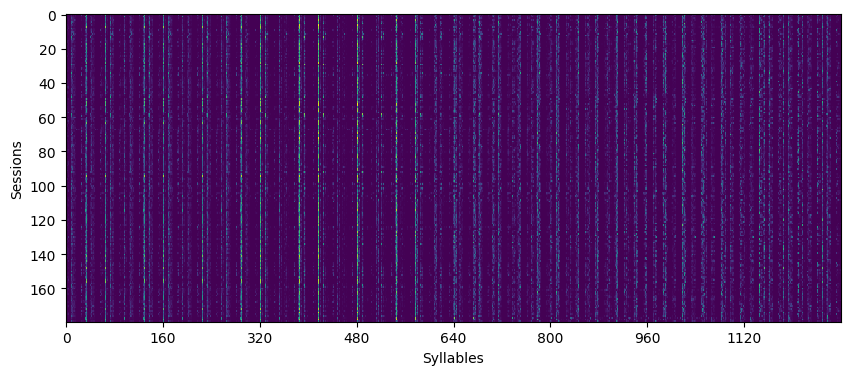

In [13]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.xlabel('Syllables')
plt.ylabel('Sessions')

Text(0.5, 1.0, 'Explained Variance by PCA')

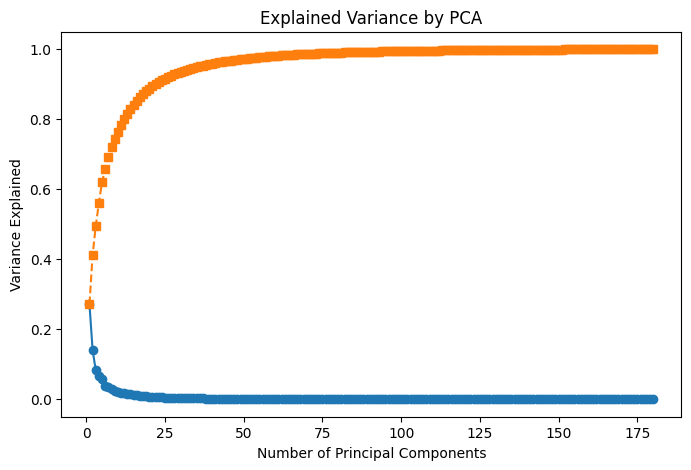

In [14]:
# PCA
n_components = np.shape(np.array(session_syllables))[0]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(np.array(session_syllables))
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(np.array(session_syllables))

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [15]:
min_components = np.where(cumulative_variance>0.95)[0][0]

Text(0, 0.5, 'Sessions')

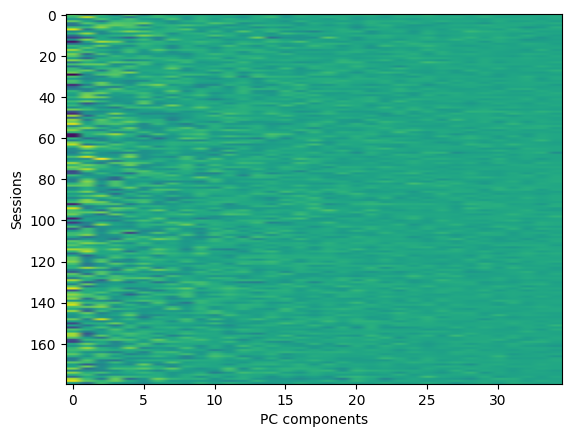

In [16]:
plt.imshow(X_pca[:, :min_components], aspect='auto')
plt.xlabel('PC components')
plt.ylabel('Sessions')

# Normalize per lab

In [17]:
mat = np.array(session_syllables.copy())
mat = np.array(X_pca[:, :min_components])

lab_df = session_syllables.reset_index().merge(metadata, on='session', how='left')
norm_array = np.ones((np.shape(mat))) * np.nan

scaler = StandardScaler()
norm_pop = scaler.fit_transform(mat.copy())
    
labs = np.unique(lab_df['lab'])
labs_array = np.array(lab_df['lab']).copy()
# np.random.shuffle(labs_array)
for i, lab in enumerate(labs):
    lab_idx = np.where(labs_array==lab)[0]
    lab_data = mat[lab_idx, :]

    scaler = StandardScaler()
    scaled = scaler.fit_transform(lab_data.copy())
    norm_array[lab_idx, :] = scaled.copy()

Text(0.5, 1.0, 'Lab normalized')

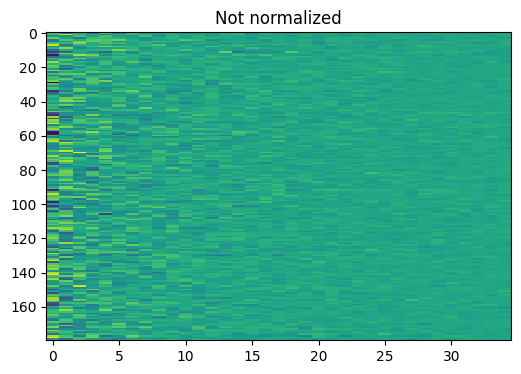

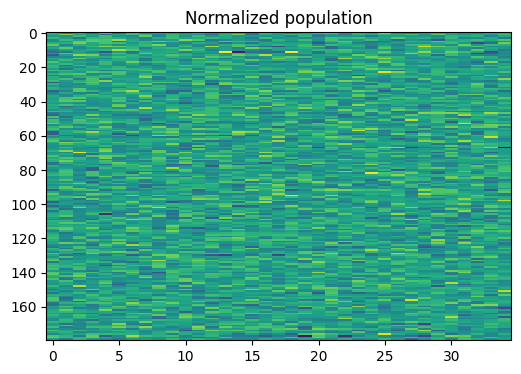

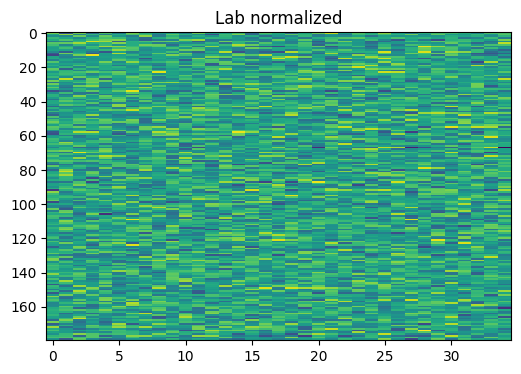

In [18]:
plt.figure(figsize=(6, 4))
plt.imshow(np.array(mat), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Not normalized')

plt.figure(figsize=(6, 4))
plt.imshow(np.array(norm_pop), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Normalized population')

plt.figure(figsize=(6, 4))
plt.imshow(np.array(norm_array), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Lab normalized')

# LDA

## Leave-one-session-out CV

In [19]:
mouse_names = session_syllables.reset_index().merge(mapping, on=['session'])['mouse_name']
lab_id = session_syllables.reset_index().merge(metadata, on=['session'])['lab']
df = session_syllables.reset_index().merge(mapping, on=['session'])
dob_df = df.merge(dob, on='mouse_name')
litter_id = dob_df['dob']

In [288]:
n_per_mouse = 3
lda_components = 20
n_repeats = 100

final_matrix = np.array(norm_array)
# final_matrix = np.array(mat)

X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]

n_samples = X.shape[0]

rng = np.random.default_rng(0)

# Store repeat results
true_scores_all = []
shuffle_scores_all = []

for repeat in range(n_repeats):

    scores_true = []
    scores_shuff = []

    # Subsample balanced sessions for training in each fold
    for test_idx in range(n_samples):

        X_test = X[test_idx:test_idx+1]
        y_test = y[test_idx:test_idx+1]

        train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
        X_train_full = X[train_idx]
        y_train_full = y[train_idx]

        # --- balanced subsampling for training ---
        balanced_idx = []
        for m in np.unique(y_train_full):
            m_idx = np.where(y_train_full == m)[0]
            if len(m_idx) >= n_per_mouse:
                balanced_idx.extend(rng.choice(m_idx, n_per_mouse, replace=False))

        balanced_idx = np.array(balanced_idx)
        X_train = X_train_full[balanced_idx]
        y_train = y_train_full[balanced_idx]

        # --- true labels run ---
        lda = LinearDiscriminantAnalysis(
            priors=np.ones(len(np.unique(y_train))) / len(np.unique(y_train)),
            n_components=lda_components)
        lda.fit(X_train, y_train)
        scores_true.append(lda.score(X_test, y_test))

        # --- shuffled labels run ---
        y_train_shuff = y_train.copy()
        rng.shuffle(y_train_shuff)
        lda_shuff = LinearDiscriminantAnalysis(
            priors=np.ones(len(np.unique(y_train_shuff))) / len(np.unique(y_train_shuff)),
            n_components=lda_components)
        lda_shuff.fit(X_train, y_train_shuff)
        scores_shuff.append(lda_shuff.score(X_test, y_test))
        
    # store average score for this repeat
    true_scores_all.append(np.mean(scores_true))
    shuffle_scores_all.append(np.mean(scores_shuff))

print("True labels mean ± std:", np.mean(true_scores_all), np.std(true_scores_all))
print("Shuffled labels mean ± std:", np.mean(shuffle_scores_all), np.std(shuffle_scores_all))


True labels mean ± std: 0.4750555555555556 0.01942848551438624
Shuffled labels mean ± std: 0.01983333333333333 0.0107512560276853


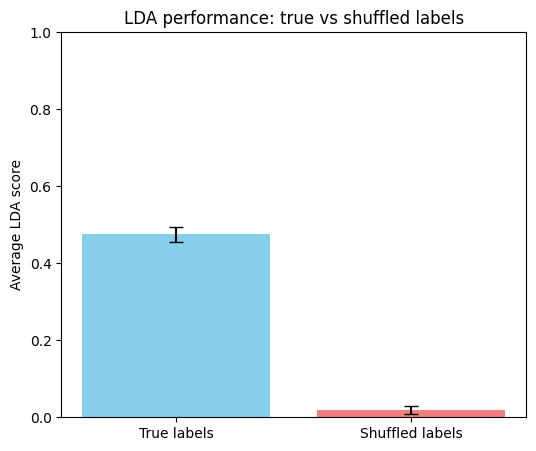

In [289]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to arrays for convenience
true_scores = np.array(true_scores_all)
shuffle_scores = np.array(shuffle_scores_all)

# Compute means and standard deviations
means = [np.mean(true_scores), np.mean(shuffle_scores)]
stds  = [np.std(true_scores), np.std(shuffle_scores)]
std_errs = [np.std(true_scores)/np.sqrt(len(true_scores)), 
            np.std(shuffle_scores)/np.sqrt(len(shuffle_scores))]

labels = ['True labels', 'Shuffled labels']

# Create bar plot with error bars
plt.figure(figsize=(6,5))
plt.bar(labels, means, yerr=stds, capsize=5, color=['skyblue','lightcoral'])
plt.ylabel('Average LDA score')
plt.title('LDA performance: true vs shuffled labels')
plt.ylim(0,1)
plt.show()


In [290]:
# --- fit LDA ---
lda = LinearDiscriminantAnalysis(priors=np.ones(len(np.unique(y_train))) / 
                                    len(np.unique(y_train)), n_components=lda_components)

lda.fit(X_train, y_train)
final_transformed = lda.transform(X_train_full)
clustered = pd.DataFrame(final_transformed)
clustered['mouse_name'] = mouse_names
clustered['lab'] = lab_id
clustered['lab_number'] = pd.factorize(clustered['lab'])[0]
clustered['litter_id'] = litter_id
clustered['litter_number'] = pd.factorize(clustered['litter_id'])[0]

clustered = clustered.merge(cluster_df[['mouse_name', 'mouse_cluster']].drop_duplicates(), on=['mouse_name'])

In [291]:
import plotly.graph_objects as go
from matplotlib import cm

# get tab10 RGBA colors from matplotlib
tab10 = cm.get_cmap('tab10')
colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})' 
          for r, g, b, a in tab10(np.linspace(0, 1, 10))]

fig = go.Figure(
    data=go.Scatter3d(
        x=clustered[0],
        y=clustered[1],
        z=clustered[2],
        mode='markers',
        marker=dict(
            size=5,
            color=[colors[c] for c in clustered['mouse_cluster']]  # assign tab10 color per cluster
        )))

fig.show()


/tmp/ipykernel_25153/1589267432.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



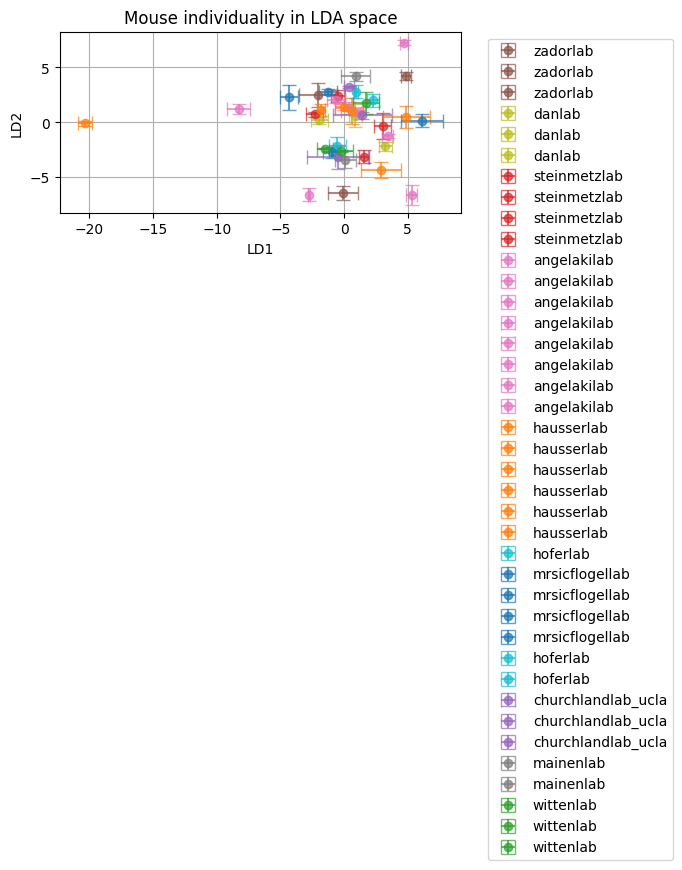

In [292]:
# clustered.groupby(['mouse_name', 'lab', 'lab_number', 'mouse_cluster', 'litter_number'])[np.arange(0, 20, 1)].mean()


# Example: df_lda has columns 'LD1', 'LD2', 'mouse'
df_lda = clustered.copy()  # your LDA-projected dataframe

# Group by mouse
grouped = df_lda.groupby(['mouse_name', 'lab', 'lab_number', 'mouse_cluster', 'litter_number'])

# Compute mean and std for each mouse
mouse_means = grouped[[0, 1]].mean()
mouse_stds  = grouped[[0, 1]].std()/np.sqrt(4)

# Plot
plt.figure(figsize=(7,6))
colors = sns.color_palette('tab10', 10)
for mouse in mouse_means.index:
    mean_vals = mouse_means.loc[mouse]
    std_vals = mouse_stds.loc[mouse]
    
    plt.errorbar(
        mean_vals[0], mean_vals[1],
        xerr=std_vals[0], yerr=std_vals[1],
        fmt='o', capsize=5, label=str(mouse[1]), color=colors[mouse[2]], alpha=0.7)  # label=str(mouse[2]),  color=colors[mouse],

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Mouse individuality in LDA space')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
# plt.xlim([-10, 8])
# plt.xlim([-10, 8])
# plt.legend('')
plt.tight_layout()
plt.show()


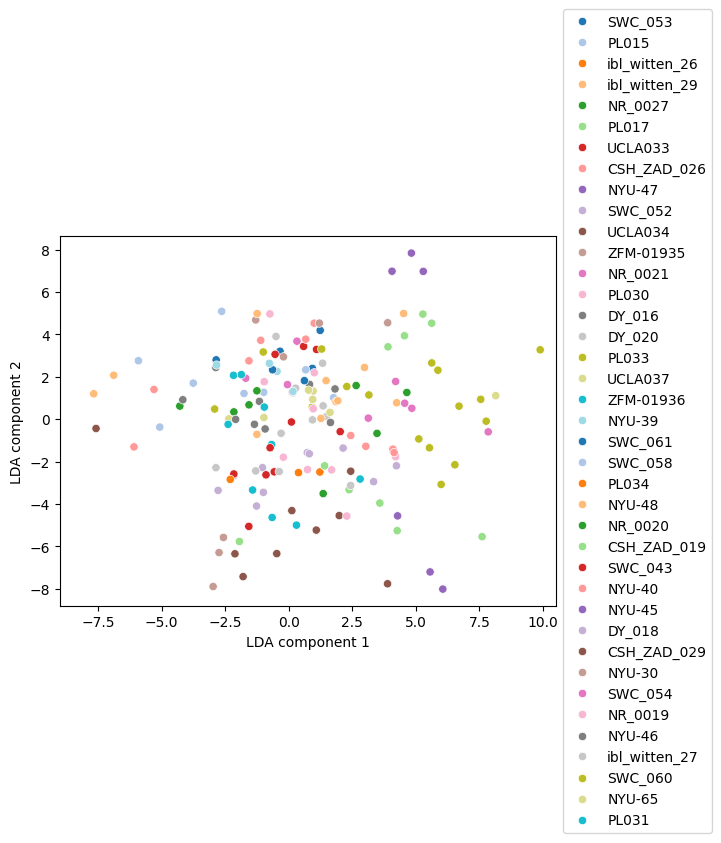

Text(0, 0.5, 'LDA component 2')

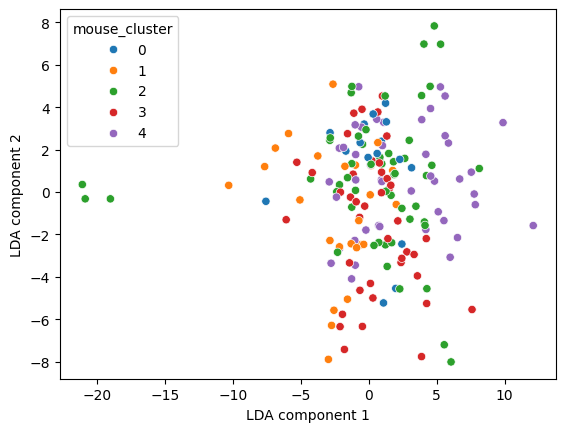

In [293]:
sns.scatterplot(x=0, y=1, hue='mouse_name', data=clustered, palette='tab20')
# plt.legend('')
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([-9, 10.5])
plt.show()
sns.scatterplot(x=0, y=1, hue='mouse_cluster', data=clustered, palette='tab10')
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
# plt.legend('')
# plt.xlim([-5, 5])


In [253]:
np.sum(lda.explained_variance_ratio_)

np.float64(0.9981282002737476)

Text(0.5, 0, 'LDA components')

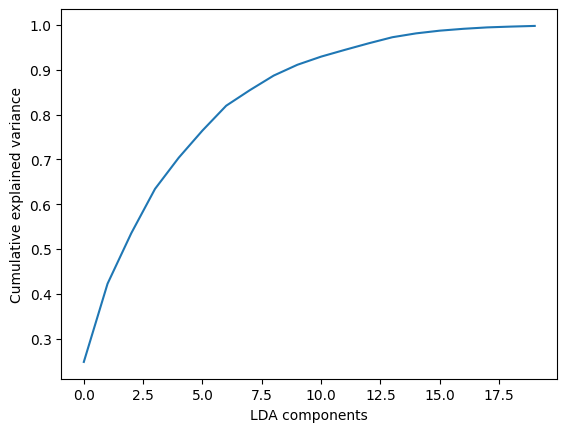

In [254]:
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('LDA components')

# Train/ test mouse correlations

In [286]:
n_per_mouse = 3
lda_components = 20

lda_to_check = 4

final_matrix = np.array(norm_array)
# final_matrix = np.array(mat)

X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]

n_samples = X.shape[0]
mouse_means = np.zeros(len(y)) * np.nan
ld_held_out = np.zeros(len(y)) * np.nan

# Subsample balanced sessions for training in each fold
for test_idx in range(n_samples):
    
    X_test = X[test_idx:test_idx+1]
    y_test = y[test_idx:test_idx+1]

    train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
    X_train_full = X[train_idx]
    y_train_full = y[train_idx]

    # --- balanced subsampling for training ---
    balanced_idx = []
    for m in np.unique(y_train_full):
        m_idx = np.where(y_train_full == m)[0]
        if len(m_idx) >= n_per_mouse:
            balanced_idx.extend(rng.choice(m_idx, n_per_mouse, replace=False))

    balanced_idx = np.array(balanced_idx)
    X_train = X_train_full[balanced_idx]
    y_train = y_train_full[balanced_idx]

    # --- true labels run ---
    lda = LinearDiscriminantAnalysis(
        priors=np.ones(len(np.unique(y_train))) / len(np.unique(y_train)),
        n_components=lda_components)
    
    lda.fit(X_train, y_train)
    transformed = lda.transform(X_train)
    mouse_means[test_idx] = np.mean(transformed[y_train == y_test, lda_to_check])  # LD1
    ld_held_out[test_idx] = lda.transform(X_test)[0][lda_to_check]  # if multiple sessions, take mean

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/

PearsonRResult(statistic=np.float64(0.6243423330761619), pvalue=np.float64(2.793194887943309e-16))


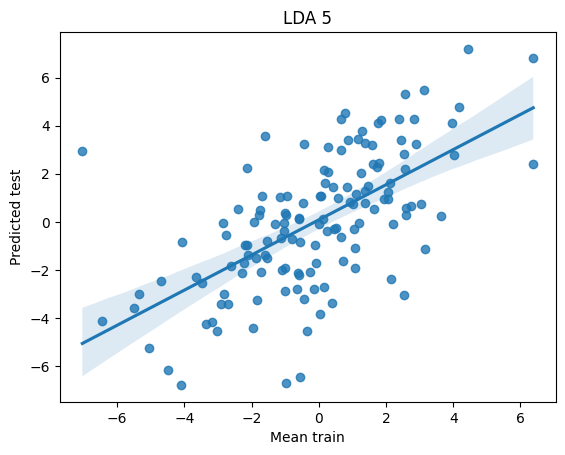

In [287]:
corr_df = pd.DataFrame(columns=['mean_train', 'transformed_test'])
corr_df['mean_train'] = mouse_means
corr_df['transformed_test'] = ld_held_out
corr_df = corr_df.dropna()

sns.regplot(x=np.array(corr_df['mean_train']).astype(float), y=corr_df['transformed_test'].astype(float), ci=95) 
plt.xlabel('Mean train')
plt.ylabel('Predicted test')
plt.title('LDA '+str(lda_to_check+1))

res = stats.pearsonr(np.array(corr_df['mean_train']).astype(float), corr_df['transformed_test'].astype(float))
print(res)